In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from scipy.special import gamma, gammaln
import sys
sys.path.append('../')
import retro

In [6]:
GCD_FILE = retro.DETECTOR_GCD_DICT_FILE
gcd = np.load(GCD_FILE)
geom, rde, noise_rate_hz = gcd['geo'], gcd['rde'], gcd['noise']

In [7]:
def KS(a,b):
    '''
    calcuate KS score for two distributions
    '''
    a_cdf = np.cumsum(a/np.sum(a))
    b_cdf = np.cumsum(b/np.sum(b))
    return np.max(np.abs(a_cdf-b_cdf))

In [8]:
def poisson(k,l):
    return np.exp(-l) * l**k / gamma(k+1)
def poisson_ln(k,l):
    return -l + k*np.log(l) - gammaln(k+1)

In [13]:
# downgoing track
with open('/home/peller/retro/icetray_processing/downgoing_track_step4_SplitUncleanedInIcePulses.pkl', 'rb') as f:
    ref = pickle.load(f)
with open('/data/icecube/retro/sims/MuMinus_energy20_x0_y0_z-300_cz+1_az0_ice_spice_mie_holeice_as.h2-50cm_gcd_md5_14bd15d0_geant_false_nsims10000000_step1_photon_histos.pkl', 'rb') as f:
    test = pickle.load(f)
with open('/home/peller/dom_pdfs/downgoing_muon/clsim_tables_pdenorm_dt1.0_sigma10deg_100phi_CKVangle_r2_x_dr_more_doms/run_info.pkl', 'rb') as f:
    retro_hist = pickle.load(f)

In [15]:
# upging track (add new retro)
with open('/home/peller/retro/icetray_processing/track_step4_SplitUncleanedInIcePulses.pkl', 'rb') as f:
    ref = pickle.load(f)
with open('/data/icecube/retro/sims/MuMinus_energy20_x0_y0_z-400_cz-1_az0_ice_spice_mie_holeice_as.h2-50cm_gcd_md5_14bd15d0_geant_false_nsims10000000_step1_photon_histos.pkl', 'rb') as f:
    test = pickle.load(f)
#with open('/home/peller/dom_pdfs/upgoing_muon/clsim_tables_pdenorm_dt1.0_sigma10deg_100phi_CKVangle/run_info.pkl', 'rb') as f:
with open('/home/peller/dom_pdfs/upgoing_muon/clsim_tables_pdenorm_dt1.0_sigma10deg_100phi_CKVangle_r2_x_dr_more_doms/run_info.pkl', 'rb') as f:
    retro_hist = pickle.load(f)

In [11]:
# horizontal track (photon hist missing)
with open('/home/peller/retro/icetray_processing/horizontal_track_step4_SplitUncleanedInIcePulses.pkl', 'rb') as f:
    ref = pickle.load(f)
with open('/data/icecube/retro/sims/MuMinus_energy20_x0_y0_z-350_cz0_az0_ice_spice_mie_holeice_as.h2-50cm_gcd_md5_14bd15d0_geant_false_nsims10000000_step1_photon_histos.pkl', 'rb') as f:
    test = pickle.load(f)
with open('/home/peller/dom_pdfs/horizontal_muon/clsim_tables_pdenorm_dt1.0_sigma10deg_100phi_CKVangle_r2_x_dr_more_doms/run_info.pkl', 'rb') as f:
    retro_hist = pickle.load(f)

In [25]:
#len(test['results'][(86,36)])
len(retro_hist['results'][(86,36)]['pexp_at_hit_times'])
retro_hist['bin_edges']

KeyError: 'bin_edges'

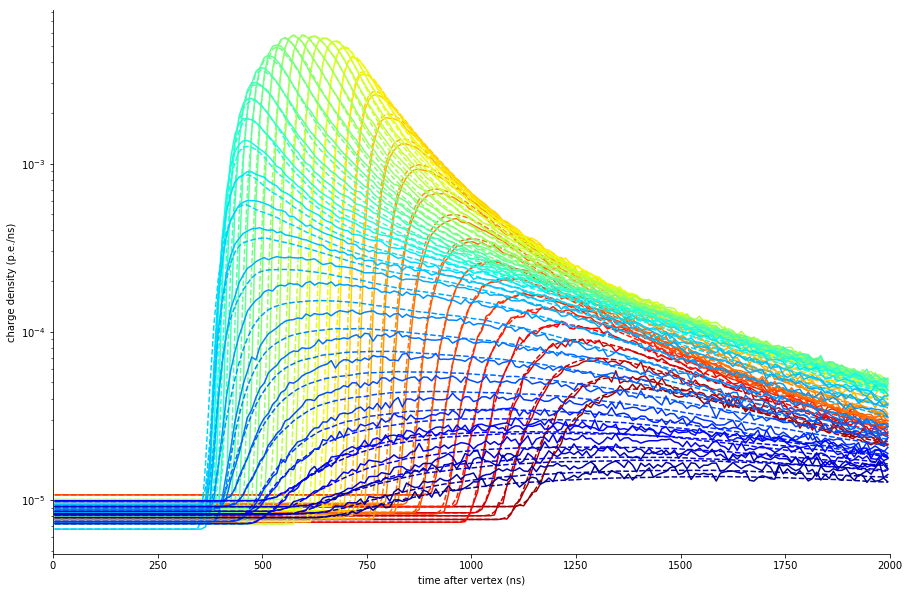

In [34]:
import matplotlib.lines as mlines
plt.figure(figsize=(15,10))
string = 85
doms = range(10,61)
bin_edges = test['bin_edges'][:201]
bins = 0.5 * (bin_edges[1:] + bin_edges[:-1])
cmap = plt.get_cmap('jet_r')

for i, dom in enumerate(doms):
    try:
        plt.plot(bins, test['results'][(string,dom)][:200], color=cmap(float(i)/len(doms)), alpha=1.)#, label='photon hist')
        plt.plot(bins, retro_hist['results'][(string,dom)]['pexp_at_hit_times']/1.2, color=cmap(float(i)/len(doms)), ls='--')#, label='retro')
    except KeyError:
        pass
        #plt.gca().legend(loc='upper right',ncol=1, frameon=False,numpoints=1,fontsize=8)
plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.xlabel('time after vertex (ns)')
plt.ylabel('charge density (p.e./ns)')
plt.gca().set_xlim(0,2000)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# legend
solid = mlines.Line2D([], [], color='k', label=r'CLsim ($10^7$ oversampling)')
dashed = mlines.Line2D([], [], color='k', ls='--', label='retro')
#plt.legend(handles=[solid, dashed])

plt.savefig('retro_vs_clsim.png', transparent=True, dpi=1200)
#print np.sum(test['results'][(string,dom)])
#print np.sum(retro_hist['results'][(string,dom)]['pexp_at_hit_times']/1.2)

In [57]:
#strings = [79, 80, 81, 82, 83, 84, 85, 86]
strings = range(1,87)
doms = range(1,61)

ratios = np.zeros((86,60))
poisson_ps = np.zeros((86,60))
KS_score = np.zeros((86,60))
ks_list = []
poisson_list = []
ratio_list = []
x_list = []
y_list = []
z_list = []
rho_list = []


for string in strings:
    for dom in doms:
        try:
            k = np.sum(retro_hist['results'][(string,dom)]['pexp_at_hit_times']/1.2)
            l = np.sum(test['results'][(string,dom)])
            ratios[string-1, dom-1] = k/l
            poisson_ps[string-1,dom-1] = poisson(k,l)
            #if poisson_ps[string-1,dom-1] < 0.4:
            #    print string, dom, k, l
            
            KS_score[string-1,dom-1] = KS(retro_hist['results'][(string,dom)]['pexp_at_hit_times'],  test['results'][(string,dom)])
            ratio_list.append(ratios[string-1, dom-1])
            ks_list.append(KS_score[string-1,dom-1])
            poisson_list.append(poisson_ps[string-1,dom-1])
            x_list.append(geom[string-1,dom-1,0])
            y_list.append(geom[string-1,dom-1,1])
            z_list.append(geom[string-1,dom-1,2])
            rho_list.append(np.sqrt(geom[string-1,dom-1,0]**2 + geom[string-1,dom-1,1]**2))
        except KeyError:
            pass
        
#plt.hist(ratio_list, bins=100)
#plt.xlabel("that's how much we're off")
#print np.mean(ratio_list)

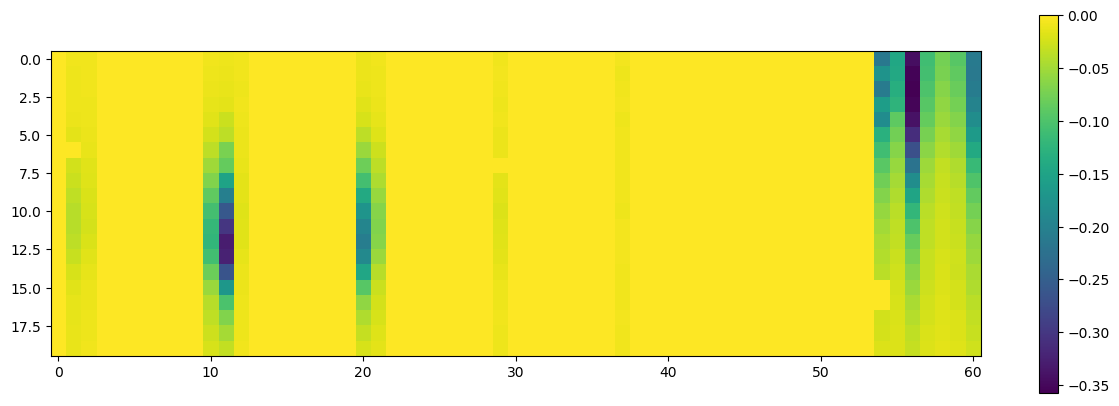

In [25]:
plt.figure(figsize=(15,5))
#plt.imshow(ratios[:,:].T)
#plt.imshow(KS_score[25:,40:].T)
plt.imshow(poisson_ps[25:,40:].T)
plt.colorbar()

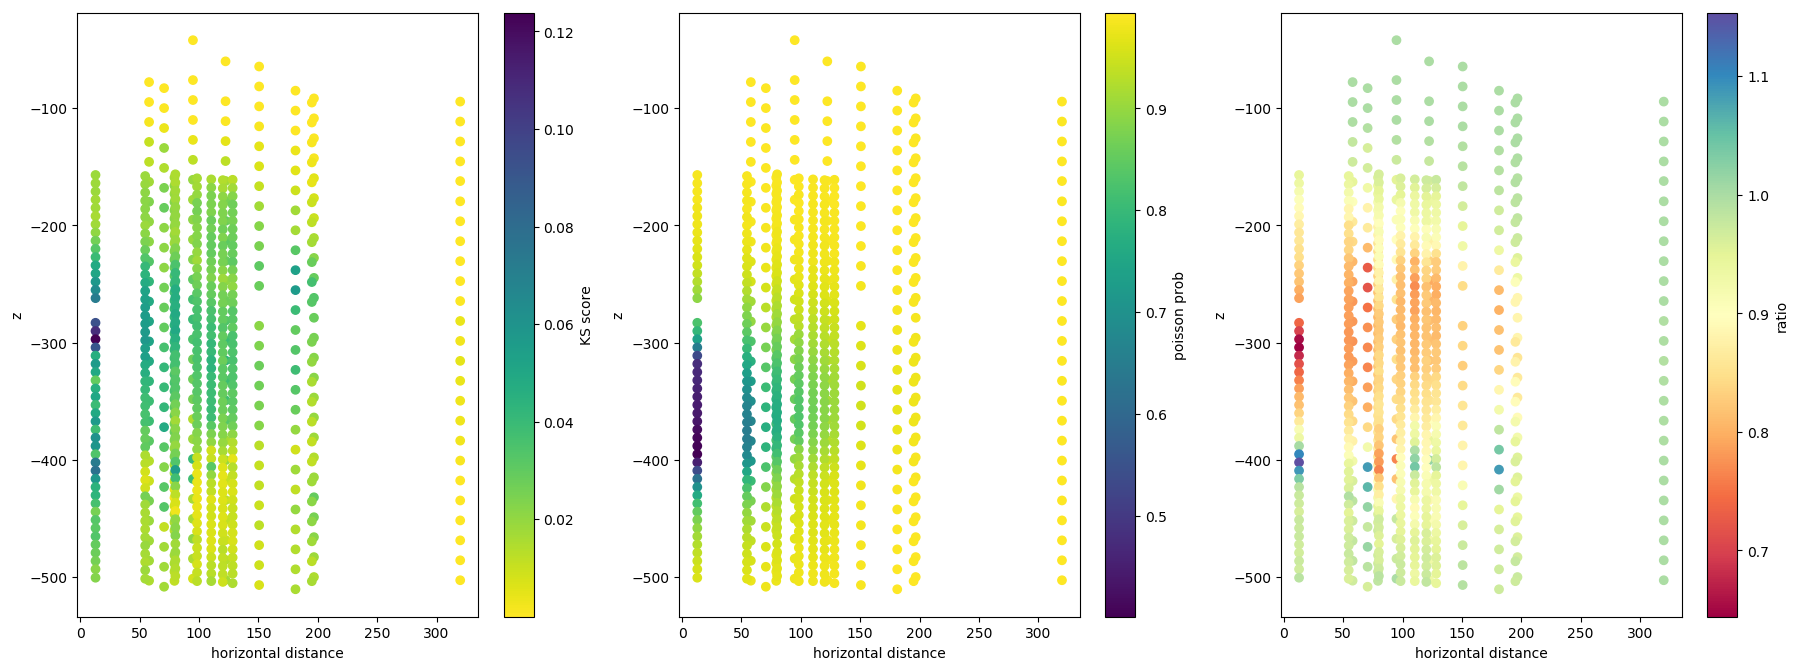

In [58]:
# plot x-y scatter
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(22, 8), ncols=3)

ks_scatter = ax1.scatter(rho_list, z_list, c=ks_list, cmap='viridis_r')
ax1.set_xlabel('horizontal distance')
ax1.set_ylabel('z')
cbar = plt.colorbar(ks_scatter, ax=ax1)
#ax1.arrow(0,-400,0,100, ec='r', fc='r', head_width=5)
cbar.set_label('KS score')

p_scatter = ax2.scatter(rho_list, z_list, c=poisson_list)
ax2.set_xlabel('horizontal distance')
ax2.set_ylabel('z')
#ax2.arrow(0,-400,0,100, ec='r', fc='r', head_width=5)
cbar = plt.colorbar(p_scatter, ax=ax2)
cbar.set_label('poisson prob')

p_scatter = ax3.scatter(rho_list, z_list, c=ratio_list, cmap='Spectral')
ax3.set_xlabel('horizontal distance')
ax3.set_ylabel('z')
#ax3.arrow(0,-400,0,100, ec='r', fc='r', head_width=5)
cbar = plt.colorbar(p_scatter, ax=ax3)
cbar.set_label('ratio')

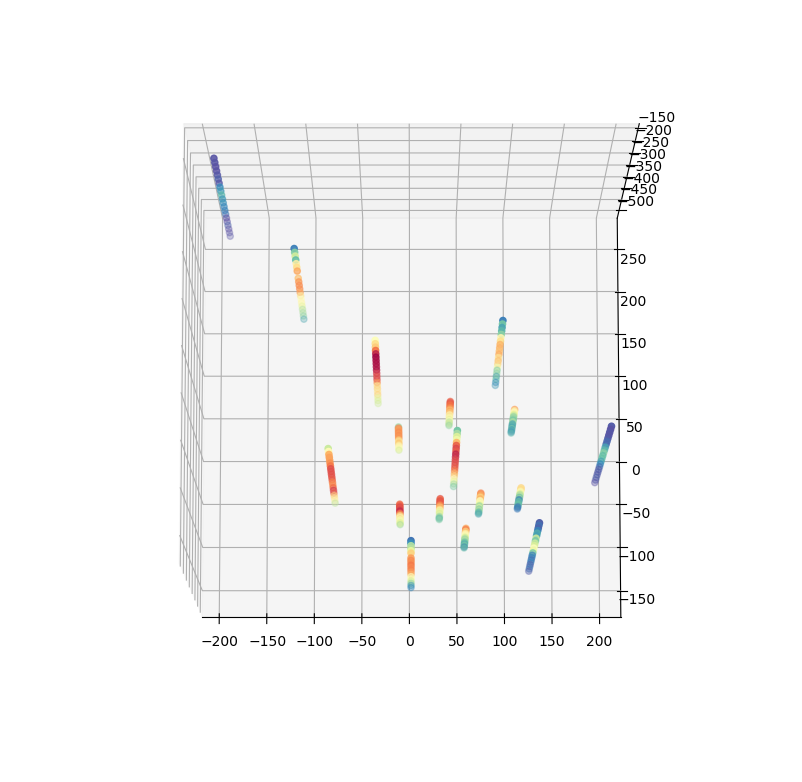

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(80, 270)
ax.scatter(x_list, y_list, z_list, c=ratio_list, cmap='Spectral')

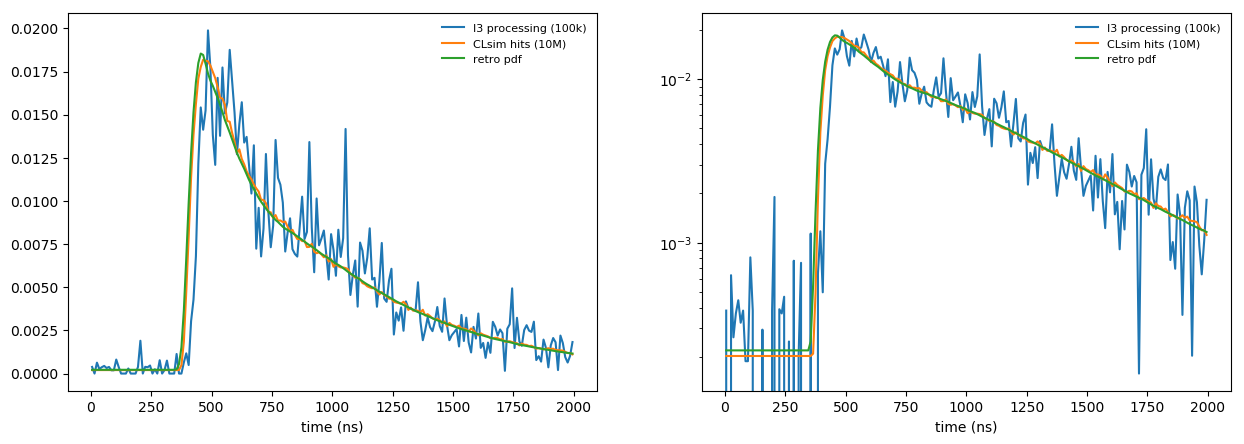

In [47]:
# normed histos:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2)
string = 86
dom = 45
bin_edges = test['bin_edges']
for ax in [ax1, ax2]:
    ax.plot(bins, ref[string-1][dom-1]/np.sum(ref[string-1][dom-1]), label='I3 processing (100k)')
    ax.plot(bins, test['results'][(string-1,dom-1)]/np.sum(test['results'][(string-1,dom-1)]), label='CLsim hits (10M)')
    ax.plot(bins, retro_hist['results'][(string-1,dom-1)]['pexp_at_hit_times'] / np.sum(retro_hist['results'][(string-1,dom-1)]['pexp_at_hit_times']), label='retro pdf')
    ax.legend(loc='upper right',ncol=1, frameon=False,numpoints=1,fontsize=8)
    ax.set_xlabel('time (ns)')
ax2.set_yscale('log')